# **MOBILENET-V2 FOR X-RAY IMAGES**

In [1]:
from google.colab import drive #mounting Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/full" #unzipping dataset

Streaming output truncated to the last 5000 lines.
  inflating: full/train/normal/Normal-10010.png  
  inflating: __MACOSX/full/train/normal/._Normal-10010.png  
  inflating: full/train/normal/Normal-2408.png  
  inflating: __MACOSX/full/train/normal/._Normal-2408.png  
  inflating: full/train/normal/Normal-716.png  
  inflating: __MACOSX/full/train/normal/._Normal-716.png  
  inflating: full/train/normal/Normal-7564.png  
  inflating: __MACOSX/full/train/normal/._Normal-7564.png  
  inflating: full/train/normal/Normal-10004.png  
  inflating: __MACOSX/full/train/normal/._Normal-10004.png  
  inflating: full/train/normal/Normal-1883.png  
  inflating: __MACOSX/full/train/normal/._Normal-1883.png  
  inflating: full/train/normal/Normal-9575.png  
  inflating: __MACOSX/full/train/normal/._Normal-9575.png  
  inflating: full/train/normal/Normal-1897.png  
  inflating: __MACOSX/full/train/normal/._Normal-1897.png  
  inflating: full/train/normal/Normal-4737.png  
  inflating: __MACOSX/full

In [ ]:
#importing libraries
import cv2
import pandas as pd
import os
import numpy as np
import cv2
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
images=[]
labels=[]

In [ ]:
a="/content/CTfull/train/covid/" #path for covid positive images (train)

In [ ]:
#loading images & labels from the path
for item in os.listdir(a):
    c=str(a+item)
    img = cv2.imread(c) 
    

    width = 224
    height = 224
    dim = (width, height)
    try:
        resized = cv2.resize(img, dim , interpolation=cv2.INTER_AREA) #resizing the images
    except:
        break
        print("b")
    images.append(resized)
    labels.append("1") #1 for covid-pos
    
for item in os.listdir("/content/CTfull/train/normal/"): #path for covid negative images (train)
    img = cv2.imread("/content/CTfull/train/normal/"+item) 
    width=224
    height=224
    dim=(width,height)
    try:
        res = cv2.resize(img, dim , interpolation=cv2.INTER_AREA)
       
    except:
        print("b")
        break
    images.append(res)
    labels.append("0") #0 for covid neg
    

In [ ]:
images=np.asarray(images) #converting to numpy arrays

In [ ]:
images.shape

(3000, 224, 224, 3)

In [ ]:
labels=np.asarray(labels) #converting the labels to an array

In [ ]:
trainy=labels.astype("uint8")

In [ ]:
#creating a dataframe by combining training images and their corresponding labels to shuffle in the next step
df = pd.DataFrame(list(zip(images, labels)), 
               columns =['Image', 'Label'])

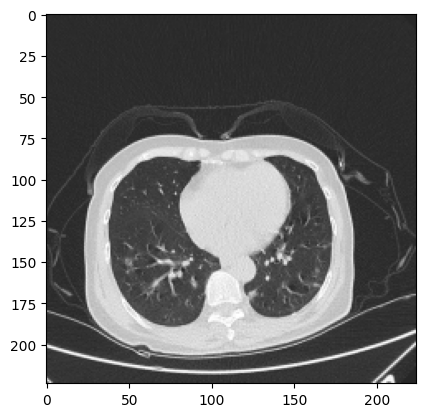

In [ ]:
plt.imshow(images[0]) #plotting an image from the training set

In [ ]:
#shuffling the df created above to disperse covid positive and negative across the training set
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
trainx=df["Image"] #converting the df back to two numpy arrays containing images and labels

In [ ]:
trainy=df["Label"]

In [ ]:
trainx=np.asarray(trainx)

In [ ]:
traindata=[]
for i in range (len(trainx)):
    trx=trainx[i]
    traindata.append(trx)

In [ ]:
traindata=np.asarray(traindata)

In [ ]:
traindata.shape

(3000, 224, 224, 3)

In [ ]:
trainy=np.asarray(trainy)

In [ ]:
trainy=trainy.astype("uint8")

In [ ]:
import keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
#Using MobileNetv2 model (pre trained on ImageNet) with hyper parameter tuning
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def create_model(learning_rate, num_filters):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_filters, activation='relu')(x)
    output_layer = layers.Dense(1, activation='sigmoid')(x)
    model = keras.models.Model(inputs=base_model.input, outputs=output_layer)
    return model
#parameters for tuning
learning_rate_schedules = [ExponentialDecay(1e-3, decay_steps=10000, decay_rate=0.96, staircase=True),
                           ExponentialDecay(1e-4, decay_steps=10000, decay_rate=0.96, staircase=True),
                           ExponentialDecay(1e-5, decay_steps=10000, decay_rate=0.96, staircase=True)]
num_filters = [32, 64, 128]

def create_and_compile_model(learning_rate, num_filters):
    model = create_model(learning_rate, num_filters)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)
param_dist = dict(learning_rate=learning_rate_schedules,
                  num_filters=num_filters)
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=4, cv=3) #random search hyperparameter tuning
random_search.fit(traindata, trainy)

print('Best score:', random_search.best_score_)
print('Best parameters:', random_search.best_params_)


<ipython-input-32-2cb38338d7c5>:31: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)


Best score: 0.5433333118756613
Best parameters: {'num_filters': 128, 'learning_rate': <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x7f1acc1b3340>}


In [ ]:
best_params = random_search.best_params_ #loading the best parameters

In [ ]:
model = create_and_compile_model(best_params['learning_rate'], best_params['num_filters'])

In [ ]:
#Using the best parameters to train the model
model.fit(traindata, trainy, epochs=39)

Epoch 1/39
94/94 [==============================] - 47s 125ms/step - loss: 0.4084 - accuracy: 0.8507
Epoch 2/39
94/94 [==============================] - 12s 125ms/step - loss: 0.1461 - accuracy: 0.9753
Epoch 3/39
94/94 [==============================] - 12s 131ms/step - loss: 0.0723 - accuracy: 0.9900
Epoch 4/39
94/94 [==============================] - 12s 125ms/step - loss: 0.0403 - accuracy: 0.9940
Epoch 5/39
94/94 [==============================] - 11s 122ms/step - loss: 0.0275 - accuracy: 0.9973
Epoch 6/39
94/94 [==============================] - 11s 121ms/step - loss: 0.0238 - accuracy: 0.9970
Epoch 7/39
94/94 [==============================] - 11s 121ms/step - loss: 0.0149 - accuracy: 0.9983
Epoch 8/39
94/94 [==============================] - 12s 124ms/step - loss: 0.0135 - accuracy: 0.9980
Epoch 9/39
94/94 [==============================] - 13s 138ms/step - loss: 0.0116 - accuracy: 0.9990
Epoch 10/39
94/94 [==============================] - 11s 121ms/step - loss: 0.0071 - accura

In [ ]:
a="/content/full/test/covid/" #path for covid positive test images

In [ ]:
#performing the same process as described above on the test set.
images=[]
labels=[]

In [ ]:
#preparing test data..
for item in os.listdir(a):
    c=str(a+item)
    img = cv2.imread(c) 
    width = 224
    height = 224
    dim = (width, height)
    try:
        resized = cv2.resize(img, dim , interpolation=cv2.INTER_AREA) #resizing
    except:
        break
        print("b")
    images.append(resized)
    labels.append("1")

for item in os.listdir("/content/full/test/normal/"): #path for covid negatuve test images
    img = cv2.imread("/content/full/test/normal/"+item) 
    width=224
    height=224
    dim=(width,height)
    try:
        res = cv2.resize(img, dim , interpolation=cv2.INTER_AREA)     
    except:
        print("b")
        break
    images.append(res)
    labels.append("0")

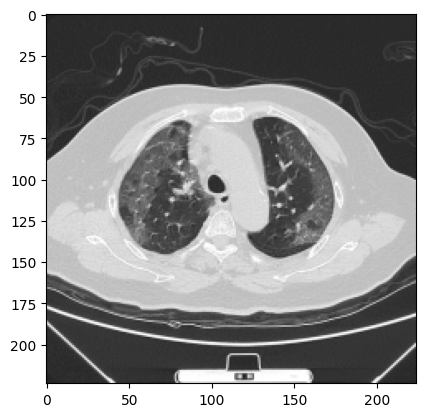

In [ ]:
plt.imshow(images[100])

In [ ]:
images=np.asarray(images)

In [ ]:
labels=np.asarray(labels)

In [ ]:
testy=labels.astype("uint8")

In [ ]:
#creating test df of test images and their corresponding labelsto shuffle in the next steps
dframe = pd.DataFrame(list(zip(images, labels)), 
               columns =['Image', 'Label'])

In [ ]:
from sklearn.utils import shuffle
dframe = shuffle(dframe) #shuffling df

In [ ]:
testx=dframe["Image"] 

In [ ]:
testy=dframe["Label"]

In [ ]:
testx=np.asarray(testx) #converting back to array

In [ ]:
testdata=[]
for i in range(len(testx)):
  tsx=testx[i]
  testdata.append(tsx)

In [ ]:
testdata=np.asarray(testdata)

In [ ]:
testy=np.asarray(testy)

In [ ]:
testy=testy.astype("uint8")

In [ ]:
#evaluating the model
score = model.evaluate(testdata, testy, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.003569544292986393
Test accuracy: 0.9990000128746033


In [ ]:
#generating predictions
predictions = model.predict(testdata)

32/32 [==============================] - 2s 34ms/step


In [ ]:
preds=[]
for i in range(len(predictions)):
  if(predictions[i]>=0.5):
    preds.append(int("1"))
  else:
    preds.append(int("0"))

In [ ]:
preds=np.array(preds)

In [ ]:
ctr=0
for i in range(len(preds)):
  if(preds[i]!=testy[i]):
    ctr=ctr+1
print(ctr)

1


In [ ]:
#calculating performance metrics
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

In [ ]:
precision = precision_score(testy, preds) #precision

In [ ]:
print(precision)

1.0


In [ ]:
matrix = confusion_matrix(testy, preds) #confusion matrix

In [ ]:
print(matrix)

[[500   0]
 [  1 499]]


In [ ]:
recall = recall_score(testy, preds) #recall

In [ ]:
print(recall)

0.998


In [ ]:
f1=f1_score(testy, preds) #f1-score

In [ ]:
print(f1)

0.998998998998999


<Axes: >

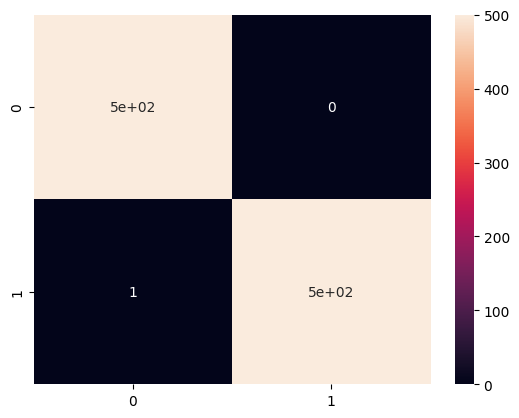

In [ ]:
import seaborn as sns #plotting confusion matrix
sns.heatmap(matrix, annot=True)

In [ ]:
kappa = cohen_kappa_score(testy, preds)#cohen kappa score
print('Cohens kappa: %f' % kappa)

Cohens kappa: 0.998000
